TIER 1:\
set up the prediction lstm on amazon data, and \
set up data-scraping from key stock website 

TIER 2:\
try to have it save and load models from a folder\
also only keep 5 models at a time, delete old ones\
test a variety of parameters of the lstm automatically, retain and save only the best ones

In [421]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

<h3>Preprocess all data</h3>
Make sure we split before we feature scale train and test (TODO)

In [422]:
initial = False # True if we have no data - tweaks may be needed
# scaler = MinMaxScaler(feature_range=(-1, 1))
# x_scaler = StandardScaler()
# y_scaler = StandardScaler()

# each model needs its own scaler
scalers = []
for i in range(4): # 0 for original, 1 for new, 2 for expanded, 3 for gru
    scalers.append(
        {
            "x_scaler":StandardScaler(),
            "y_scaler": StandardScaler()
        }
    )

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100 # 100 originally, 150 seems to give good results 
num_tune_epochs = 3 # recommended to keep # of training epochs between 3 and 10 when fine-tuning models (3-5 for simple ones) 

# True for Train, False for Load
train_or_load_original = True # separate modifier because original model's performance is very unreliable
train_or_load_new = True
train_or_load = True
train_or_load_gru = True

In [423]:
def save_data(data, date = None):
    if not date:
        date = f"{str(datetime.now()).replace(':','.')}.csv"
    os.makedirs("data", exist_ok=True)
    contents = os.listdir("data")
    for item in contents:
        if date[:10] in item:
            os.remove("data/" + item)
    if f"data/{date}" not in os.listdir("data"):
        data.to_csv("data/" + date, index=False)
        
def read_data(filepath, sort_column = None):
    data = pd.read_csv(filepath)
    if sort_column:
        data = data.sort_values(sort_column)
    data.head()
    price = data[['Close']] 
    price['Close'] = price['Close'].values.reshape(-1,1)
    return data, price

In [424]:
data = pd.read_csv("relevant-stock-data/AMZN Historical Data Fixed.csv")
data = data.iloc[::-1]
data = data[['Date', 'Open', 'High', 'Low', 'Price', 'Vol.']]
data = data.rename(columns={'Price' : 'Close', 'Vol.' : 'Volume'})
data['Name'] = ['AMZN']*len(data['Date'])

for i in range(len(data['Volume'])): # iloc for integer based assignment of multiple cells, iat for integer based assignment on a single cell
    if 'M' in data['Volume'].iat[i]:
        data['Volume'].iat[i] = str(int(float(data['Volume'].iat[i][:-1]) * 1e6))
    if 'B' in data['Volume'].iat[i]:
        data['Volume'].iat[i] = str(int(float(data['Volume'].iat[i][:-1]) * 1e9))

price = data[['Close']]
price['Close'] = price['Close'].values.reshape(-1,1)
# price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
print(price.iloc[-5:])
print(data.iloc[-5:])

    Close
4  173.67
3  179.62
2  180.96
1  175.84
0  178.97
         Date    Open    High     Low   Close    Volume  Name
4  04/25/2024  169.68  173.92  166.32  173.67  49250000  AMZN
3  04/26/2024  177.79  180.82  176.13  179.62  43920000  AMZN
2  04/29/2024  182.65  183.50  179.39  180.96  52080000  AMZN
1  04/30/2024  181.01  182.02  175.05  175.84  61800000  AMZN
0  05/01/2024  181.68  185.12  176.57  178.97  87860000  AMZN


C:\Users\noten\AppData\Local\Temp\ipykernel_10088\3546848102.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].values.reshape(-1,1)


In [425]:
def split_data(data, stock, lookback, key):
    x_scaler = scalers[key]['x_scaler']
    y_scaler = scalers[key]['y_scaler']
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    print(data.shape)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x = data[:, :-1, :]
    y = data[:, -1, :]
        
    # print(x.shape)
    # print(y.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    x_train[:,:,0] = x_scaler.fit_transform(x_train[:,:,0])
    x_test[:,:,0] = x_scaler.transform(x_test[:,:,0])
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    return [x_train, y_train, x_test, y_test]

In [426]:
# 0 for the original, 1 for our new lstm and gru, 2 for the expanded lstm 
# expected to have many models - lists preferred over dictionaries
x_trains = []
y_trains_lstm = []
x_tests = []
y_tests_lstm = []

In [427]:
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(data, price, lookback, 0)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(4593, 20, 1)
x_train.shape =  (3674, 19, 1)
y_train.shape =  (3674, 1)
x_test.shape =  (919, 19, 1)
y_test.shape =  (919, 1)


In [428]:
# Convert arrays to Pytorch arrays using .from_numpy()
# Set type to torch tensors using .type(torch.Tensor)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

In [429]:
# is this necessary? data kinda already fulfills this purpose

if not initial:
    print("data/" + os.listdir("data")[-1]) # do we save the wrong data?
    data = pd.read_csv("data/" + os.listdir("data")[-1])

data/2024-05-16 17.46.22.638728.csv


Automatically Updating Data

In [430]:
cur_time = int(str(datetime.now())[11:13])
print(cur_time) # the current hour
# While today is not in the data, keep adding rows
most_recent_date = data['Date'].iloc[-1]
# most_recent_date = most_recent_date[-4:] + "-" + most_recent_date[:2] + "-" + most_recent_date[3:5] 
print(most_recent_date) # broken lol
print(str(datetime.now())[:10])

20
05/16/2024
2024-05-16


In [431]:
def get_updated_data():
    count_today = cur_time >= 16 # has the market closed yet? T if yes, F if no.
    url = "https://www.investing.com/equities/amazon-com-inc-historical-data"
    page = requests.get(url)
        
    soup = BeautifulSoup(page.text, 'html.parser')
        
    # Need: Open, High, Low, Close, Volume, Name
    all_date_class = "freeze-column-w-1 w-full overflow-x-auto text-xs leading-4"
    table = soup.find('table', {'class': all_date_class})
    rows = table.find_all('tr')
    
    table_data = []
    for row in rows:
        row_data = []
        for cell in row.find_all(['td']):
            row_data.append(cell.text)
        if row_data and count_today:
            
            for i in range(len(row_data)):
                if 'M' in row_data[i]:
                    row_data[i] = str(int(float(row_data[i][:-1]) * 1e6)) # all data values are rounded so we round too
            # print(row_data)
            if most_recent_date in row_data:
                break # we've caught up
            table_data.append(row_data)
        else:
            count_today = True

    # print(table_data)
    return table_data

get_updated_data()

[]

In [432]:
date_updated = most_recent_date[-4:] + "-" + most_recent_date[:2] + "-" + most_recent_date[3:5] 
need_update = not date_updated == str(datetime.now())[:10] and cur_time >= 16
print(need_update)

if need_update:
    # old_data = pd.read_csv('data/' + os.listdir('data')[-1])

    # for now, we will only focus on updating day by day
    new_data = get_updated_data()[::-1] # newest dates are returned first
    start_index = len(data['Date'])
        
    for i in range(len(new_data)): # adds data backwards, please fix
        new_values = new_data[i] # comes as date, price (close), open, high, low, vol, change
    
        # new_values = get_updated_data()[0] 
        print(pd.DataFrame(new_values).head())
        
        # read, write, then save the new values inside our most recent table
        data.loc[start_index + i] = [new_values[0], new_values[2], new_values[3], new_values[4], new_values[1], new_values[5], "AMZN"] # may be deprecated in future, we'll see
    
    # print(old_data.head())
    # print(len(old_data['Date']))
    # print(old_data['Date'].iloc[-1])
    
    # result.to_csv("data/" + str(datetime.now()).replace(":",".") + ".csv", index=False)
    save_data(data)

False


In [433]:
updated_data, updated_price = read_data('data/' + os.listdir("data")[-1])
print('data/' + os.listdir("data")[-1])
print(updated_data.iloc[-5:])
print(updated_price.iloc[-5:])

data/2024-05-16 17.46.22.638728.csv
            Date    Open    High     Low   Close    Volume  Name
4619  05/10/2024  188.98  189.87  186.93  187.48  28560000  AMZN
4620  05/13/2024  188.00  188.18  185.36  186.57  21690000  AMZN
4621  05/14/2024  183.82  187.71  183.50  187.07  38630000  AMZN
4622  05/15/2024  185.97  186.65  182.85  185.99  69740000  AMZN
4623  05/16/2024  185.60  187.30  183.47  183.60  38100000  AMZN
       Close
4619  187.48
4620  186.57
4621  187.07
4622  185.99
4623  183.60


C:\Users\noten\AppData\Local\Temp\ipykernel_10088\464067802.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].values.reshape(-1,1)


In [434]:
if('2024-04-26' not in str(datetime.now())): # initial date
    if need_update:
        save_data(data)  
else:
    save_data('2024-04-26 00.00.000000')
print(str(datetime.now())[:10])

2024-05-16


In [435]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(updated_data, updated_price, lookback, 1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# print(x_train[0])
# print(y_train[0])
# print(x_test[0])
# print(y_test[0])

(4604, 20, 1)
x_train.shape =  (3683, 19, 1)
y_train.shape =  (3683, 1)
x_test.shape =  (921, 19, 1)
y_test.shape =  (921, 1)


In [436]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

In [437]:
volume_scaler = MinMaxScaler(feature_range=(-1, 1)) # The volumes are in the millions and would mess up our scaler
column_scaler = StandardScaler()

In [438]:
def split_data_expanded(data, stock, lookback):
    x_scaler = scalers[2]['x_scaler']
    y_scaler = scalers[2]['y_scaler']
    data_raw = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    stock_raw = stock.to_numpy() # convert to numpy array
    # x = []
    # y = []    
    all_data = []
    
    data_raw = data_raw.to_numpy()
    
    # create all possible sequences of length seq_len
    for index in range(len(stock_raw) - lookback): 
        all_data.append(data_raw[index: index + lookback])
    
    all_data = np.array(all_data)
    x = all_data[:,:-1,:]    
    y = all_data[:,-1,3].reshape(-1,1) # we want the price column
    # x = np.array(x)
    # y = np.array(y)
    
    print(x.shape)
    print(y.shape)
    
    test_set_size = int(np.round(0.2*y.shape[0])) # 80-20 train-test split
    train_set_size = y.shape[0] - (test_set_size)
    
    # split, then feature scale
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
    # scale all values in data_raw
    # when reading in values, we only min-max the values of stock
    
    for i in range(x.shape[2]): # each category
        # scaler.fit(x[:train_set_size,:,i])
        x_train[:,:,i] = column_scaler.fit_transform(x_train[:, :, i])
        x_test[:,:,i] = column_scaler.transform(x_test[:,:,i])
    
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    return [x_train, y_train, x_test, y_test]

# Test code
test = True
if test:
    test_data, test_stock = read_data("data/" + os.listdir("data")[-1])
    print(test_data.iloc[-5:])
    x_train, y_train, x_test, y_test = split_data_expanded(test_data, test_stock, 20)
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)

            Date    Open    High     Low   Close    Volume  Name
4619  05/10/2024  188.98  189.87  186.93  187.48  28560000  AMZN
4620  05/13/2024  188.00  188.18  185.36  186.57  21690000  AMZN
4621  05/14/2024  183.82  187.71  183.50  187.07  38630000  AMZN
4622  05/15/2024  185.97  186.65  182.85  185.99  69740000  AMZN
4623  05/16/2024  185.60  187.30  183.47  183.60  38100000  AMZN
(4604, 19, 5)
(4604, 1)
x_train.shape =  (3683, 19, 5)
y_train.shape =  (3683, 1)
x_test.shape =  (921, 19, 5)
y_test.shape =  (921, 1)


C:\Users\noten\AppData\Local\Temp\ipykernel_10088\464067802.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].values.reshape(-1,1)


In [439]:
# train, test key is 2
x_train, y_train, x_test, y_test = split_data_expanded(updated_data, updated_price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(4604, 19, 5)
(4604, 1)
x_train.shape =  (3683, 19, 5)
y_train.shape =  (3683, 1)
x_test.shape =  (921, 19, 5)
y_test.shape =  (921, 1)


In [440]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

In [441]:
# train, test key is 3
x_train, y_train, x_test, y_test = split_data(updated_data, updated_price, lookback, 3)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(4604, 20, 1)
x_train.shape =  (3683, 19, 1)
y_train.shape =  (3683, 1)
x_test.shape =  (921, 19, 1)
y_test.shape =  (921, 1)


In [442]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

<h3>Train models - one on the provided data, rest on the collected data</h3>

<h3>Also, fine-tune the models' hyperparameters </h3>

In [443]:
model_dir = "models"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = torch.nn.MSELoss(reduction='mean')

In [444]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [445]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [446]:
original_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
original_optimiser = torch.optim.Adam(original_model.parameters(), lr=0.01)

if not train_or_load_original:
    # load original model
    loaded_state = torch.load(model_dir + "/original3.pt", map_location=device)
    original_model.load_state_dict(loaded_state['model'])
    original_optimiser.load_state_dict(loaded_state['opt'])

In [447]:
def train_model(model, optimiser, data_key, num_epochs=100):
    # print(y_scaler.inverse_transform(y_trains_lstm[data_key][-1].detach().numpy().reshape(-1, 1)))
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []

    for t in range(num_epochs):
        y_train_pred = model(x_trains[data_key])

        loss = criterion(y_train_pred, y_trains_lstm[data_key])
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred, hist

In [448]:
if need_update or train_or_load_original:
    y_train_pred, hist = train_model(original_model, original_optimiser, 0, num_epochs=num_epochs)

Epoch  0 MSE:  1.0119348764419556
Epoch  1 MSE:  0.9168542623519897
Epoch  2 MSE:  0.7828004956245422
Epoch  3 MSE:  0.535524308681488
Epoch  4 MSE:  0.20569917559623718
Epoch  5 MSE:  0.1024787575006485
Epoch  6 MSE:  0.12257499247789383
Epoch  7 MSE:  0.22448758780956268
Epoch  8 MSE:  0.1487434357404709
Epoch  9 MSE:  0.07630863785743713
Epoch  10 MSE:  0.06624174863100052
Epoch  11 MSE:  0.06473947316408157
Epoch  12 MSE:  0.06761439144611359
Epoch  13 MSE:  0.07561298459768295
Epoch  14 MSE:  0.08117517083883286
Epoch  15 MSE:  0.07806763052940369
Epoch  16 MSE:  0.06705164909362793
Epoch  17 MSE:  0.054255928844213486
Epoch  18 MSE:  0.045589204877614975
Epoch  19 MSE:  0.040031030774116516
Epoch  20 MSE:  0.032047439366579056
Epoch  21 MSE:  0.024277828633785248
Epoch  22 MSE:  0.02359885349869728
Epoch  23 MSE:  0.02648254856467247
Epoch  24 MSE:  0.02552909217774868
Epoch  25 MSE:  0.023385493084788322
Epoch  26 MSE:  0.024439413100481033
Epoch  27 MSE:  0.0216684490442276
Epo

In [449]:
def graph_results(y_train_pred, hist, data_key):
    y_scaler = scalers[data_key]['y_scaler']
    predict = pd.DataFrame(y_scaler.inverse_transform(y_train_pred.detach().numpy())) # un-normalize data
    original = pd.DataFrame(y_scaler.inverse_transform(y_trains_lstm[data_key].detach().numpy())) # un-normalzie data
    
    
    concatenated = pd.concat([predict, original], axis=1)
    concatenated.columns = ["predict", "original"]
    concatenated = concatenated.sort_values(by="original")
    # print(concatenated.head())
    predict = pd.DataFrame(concatenated['predict'].values.reshape(-1,1))
    original = pd.DataFrame(concatenated['original'].values.reshape(-1,1))
    
    sns.set_style("darkgrid")    

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)


    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

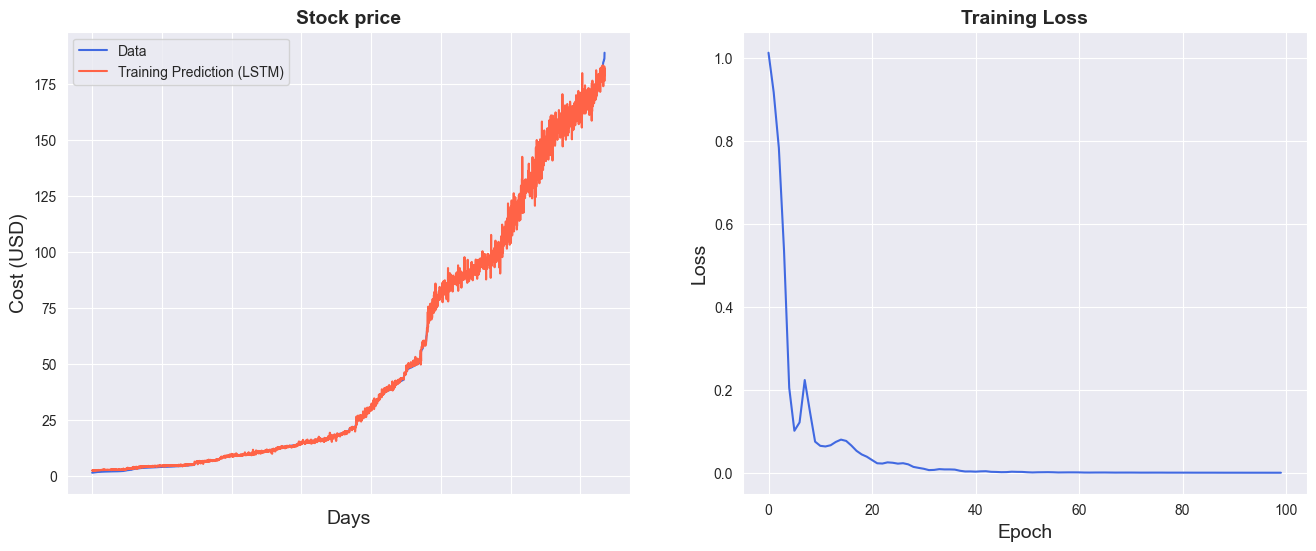

In [450]:
if need_update or train_or_load_original:
    graph_results(y_train_pred, hist, 0)

In [451]:
new_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
new_optimiser = torch.optim.Adam(new_model.parameters(), lr=0.01)

if not train_or_load_new:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'stock-only-lstm' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    new_model.load_state_dict(loaded_state['model'])
    new_optimiser.load_state_dict(loaded_state['opt'])

In [452]:
if not train_or_load_new:
    if need_update:
        y_pred, hist = train_model(new_model, new_optimiser, 1, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(new_model, new_optimiser, 1, num_epochs=num_epochs)

Epoch  0 MSE:  1.0303287506103516
Epoch  1 MSE:  0.9301226735115051
Epoch  2 MSE:  0.8184124827384949
Epoch  3 MSE:  0.6190813779830933
Epoch  4 MSE:  0.2911785840988159
Epoch  5 MSE:  0.06374488770961761
Epoch  6 MSE:  0.23522239923477173
Epoch  7 MSE:  0.2408890277147293


Epoch  8 MSE:  0.13344749808311462
Epoch  9 MSE:  0.05465618520975113
Epoch  10 MSE:  0.06435941159725189
Epoch  11 MSE:  0.1039171889424324
Epoch  12 MSE:  0.11803591996431351
Epoch  13 MSE:  0.11023255437612534
Epoch  14 MSE:  0.09386850893497467
Epoch  15 MSE:  0.07604485750198364
Epoch  16 MSE:  0.06019972264766693
Epoch  17 MSE:  0.04982833191752434
Epoch  18 MSE:  0.046819448471069336
Epoch  19 MSE:  0.04960748925805092
Epoch  20 MSE:  0.05411922186613083
Epoch  21 MSE:  0.05549236014485359
Epoch  22 MSE:  0.050271593034267426
Epoch  23 MSE:  0.03952835127711296
Epoch  24 MSE:  0.028677120804786682
Epoch  25 MSE:  0.02286108396947384
Epoch  26 MSE:  0.023374803364276886
Epoch  27 MSE:  0.027585679665207863
Epoch  28 MSE:  0.03092244267463684
Epoch  29 MSE:  0.029782066121697426
Epoch  30 MSE:  0.023913990706205368
Epoch  31 MSE:  0.01645859144628048
Epoch  32 MSE:  0.011605576612055302
Epoch  33 MSE:  0.01147274300456047
Epoch  34 MSE:  0.01426750048995018
Epoch  35 MSE:  0.01560

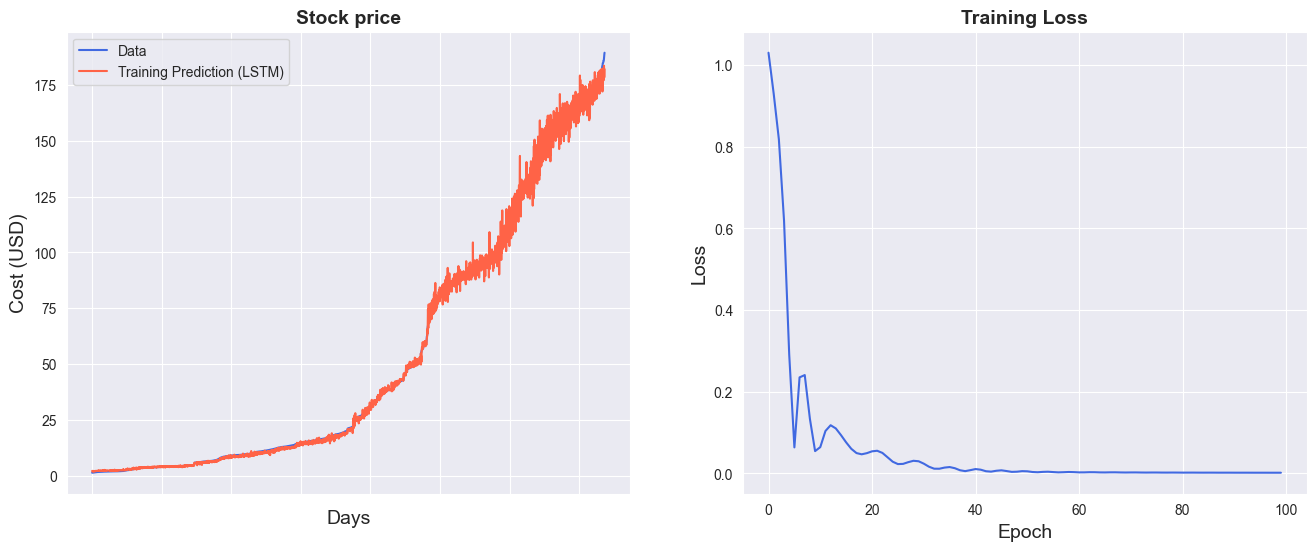

In [453]:
if need_update or train_or_load_new:
    graph_results(y_pred, hist, 1)

In [454]:
# Train a model using all traits - not just stock price
# 5 important traits - open, high, low, close, volume
# data key is 2
expanded_model = LSTM(input_dim=5, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
expanded_optimiser = torch.optim.Adam(expanded_model.parameters(), lr=0.01)

if not train_or_load:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'expanded-lstm' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    expanded_model.load_state_dict(loaded_state['model'])
    expanded_optimiser.load_state_dict(loaded_state['opt'])

if not train_or_load:
    if need_update: 
        y_pred, hist = train_model(expanded_model, expanded_optimiser, 2, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(expanded_model, expanded_optimiser, 2, num_epochs=num_epochs)
    

Epoch  0 MSE:  0.9898872375488281
Epoch  1 MSE:  0.7980701923370361
Epoch  2 MSE:  0.5601223707199097
Epoch  3 MSE:  0.2520633041858673
Epoch  4 MSE:  0.0752127394080162
Epoch  5 MSE:  0.2085537314414978
Epoch  6 MSE:  0.23485785722732544
Epoch  7 MSE:  0.1661740243434906
Epoch  8 MSE:  0.10264439135789871
Epoch  9 MSE:  0.0779043510556221
Epoch  10 MSE:  0.08361530303955078
Epoch  11 MSE:  0.09876944124698639
Epoch  12 MSE:  0.1074075996875763
Epoch  13 MSE:  0.10352030396461487
Epoch  14 MSE:  0.08905340731143951
Epoch  15 MSE:  0.0702579915523529
Epoch  16 MSE:  0.053888950496912
Epoch  17 MSE:  0.04334138333797455
Epoch  18 MSE:  0.03681161627173424
Epoch  19 MSE:  0.030548397451639175
Epoch  20 MSE:  0.024852560833096504
Epoch  21 MSE:  0.02690955251455307
Epoch  22 MSE:  0.028788737952709198
Epoch  23 MSE:  0.018151406198740005
Epoch  24 MSE:  0.013345581479370594
Epoch  25 MSE:  0.010925483889877796
Epoch  26 MSE:  0.00874625239521265
Epoch  27 MSE:  0.00956734735518694
Epoch  2

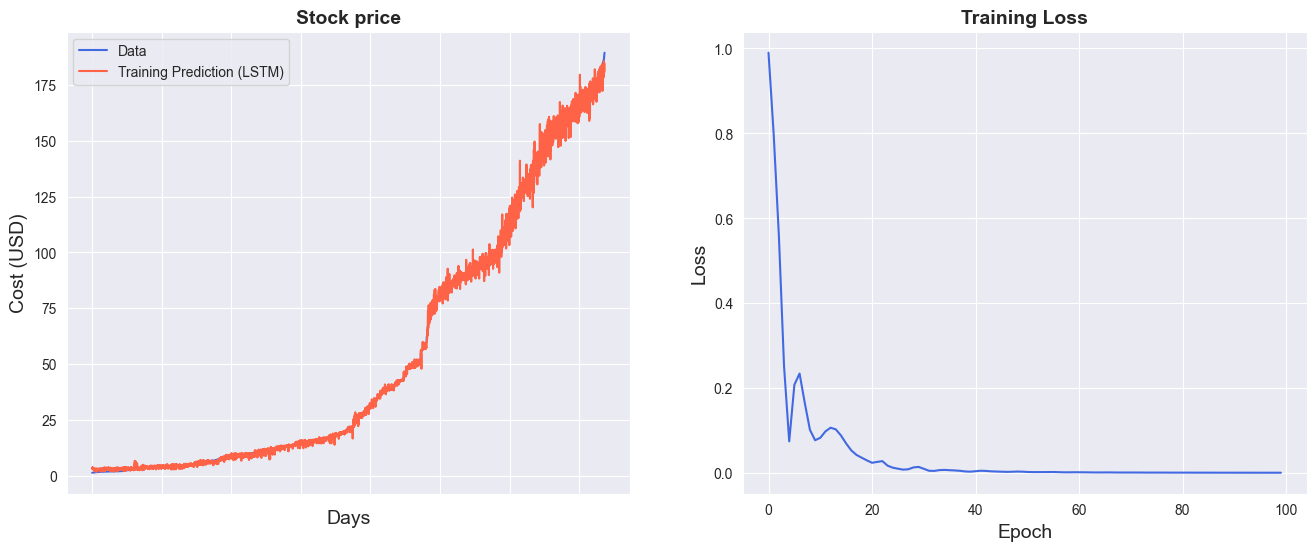

In [455]:
if need_update or train_or_load:
    graph_results(y_pred, hist, 2)

In [456]:
# use data key of 3
new_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
new_gru_optimiser = torch.optim.Adam(new_gru.parameters(), lr=0.01)

if not train_or_load_gru:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'stock-only-gru' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    new_gru.load_state_dict(loaded_state['model'])
    new_gru_optimiser.load_state_dict(loaded_state['opt'])    
    if need_update:
        y_pred, hist = train_model(new_gru, new_gru_optimiser, 3, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(new_gru, new_gru_optimiser, 3, num_epochs=num_epochs)

Epoch  0 MSE:  1.0000841617584229
Epoch  1 MSE:  0.6618706583976746


Epoch  2 MSE:  0.3355063796043396
Epoch  3 MSE:  0.046688951551914215
Epoch  4 MSE:  0.1308613121509552
Epoch  5 MSE:  0.1864062398672104
Epoch  6 MSE:  0.08298629522323608
Epoch  7 MSE:  0.020145609974861145
Epoch  8 MSE:  0.03377699851989746
Epoch  9 MSE:  0.06922072917222977
Epoch  10 MSE:  0.0853414312005043
Epoch  11 MSE:  0.07425491511821747
Epoch  12 MSE:  0.047323744744062424
Epoch  13 MSE:  0.02146686054766178
Epoch  14 MSE:  0.010114709846675396
Epoch  15 MSE:  0.016811750829219818
Epoch  16 MSE:  0.03194209188222885
Epoch  17 MSE:  0.03950191289186478
Epoch  18 MSE:  0.03310546278953552
Epoch  19 MSE:  0.019562363624572754
Epoch  20 MSE:  0.008955289609730244
Epoch  21 MSE:  0.006375188939273357
Epoch  22 MSE:  0.010418055579066277
Epoch  23 MSE:  0.016223883256316185
Epoch  24 MSE:  0.01926122047007084
Epoch  25 MSE:  0.017623908817768097
Epoch  26 MSE:  0.012456481344997883
Epoch  27 MSE:  0.006891033612191677
Epoch  28 MSE:  0.004052115138620138
Epoch  29 MSE:  0.00503474

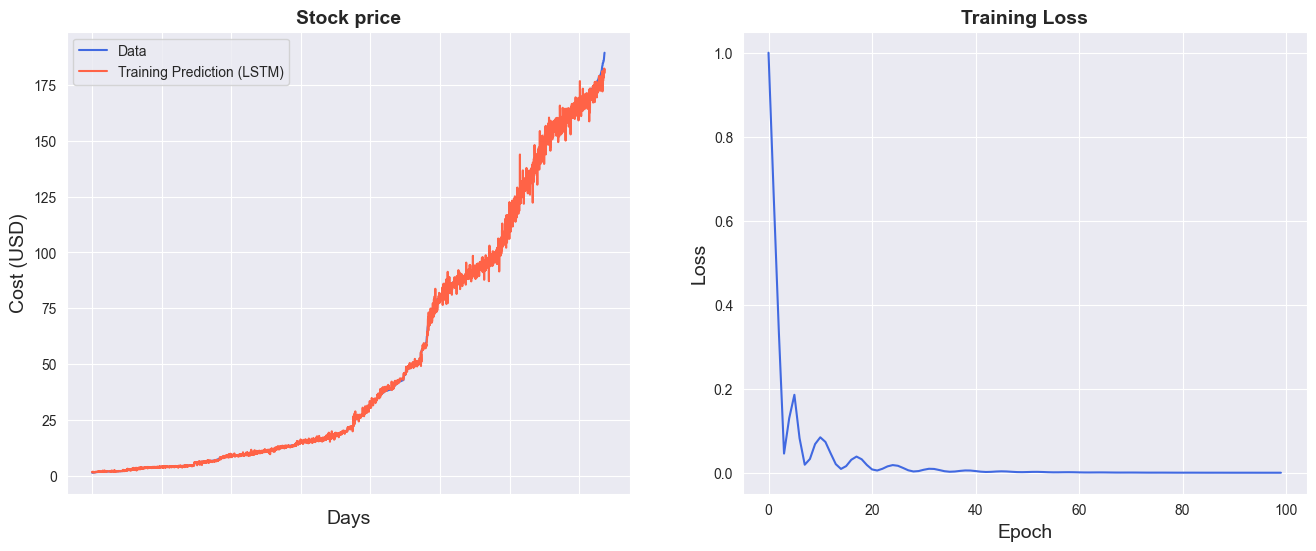

In [457]:
if need_update or train_or_load_gru:
    graph_results(y_pred, hist, 1)

<h3>Make Predictions using Models </h3>

Original and new LSTM model just do regression on the stock themselves \
Expanded model uses open, high, low, close, volume to regress stock

<h3>TODO: try implementing a regression model and have it train, save, fine-tune, and load w/ the other models.</h3>
Also, fix the expanded model's output predictions.

In [458]:
def buy_or_sell(is_buy, start, stop, prices, days):
    if is_buy:
        min_price = min(prices[start:stop])
        # print(min_price)
        for j in range(start, stop):
            if prices[j] != min_price:
                days[j] = None
    else:    
        max_sell = max(prices[start:stop])
        for j in range(start, stop):
            if prices[j] != max_sell:
                days[j] = None

def maximize_profit(prices):
    cur_hold, cur_not_hold = -float('inf'), 0
    days = [None] * len(prices)

    for i in range(len(prices)):
        # we don't have logic for taking back purchases
        stock_price = prices[i]
        prev_hold, prev_not_hold = cur_hold, cur_not_hold
        
        cur_hold = max(prev_hold, prev_not_hold - stock_price)
        if prev_hold < prev_not_hold - stock_price: # if it is more worth to buy
            days[i] = "buy"
            
        
        cur_not_hold = max(prev_not_hold, prev_hold + stock_price)
        if prev_not_hold < prev_hold + stock_price: # if it is more worth to sell
            days[i] = "sell" 

    is_buy = False
    days_to_consider = []   

    for i in range(len(days)):
        if (len(days_to_consider) > 0 and (days[i] == "buy") != is_buy):
            # print(days_to_consider)
            start, stop = days_to_consider[0], days_to_consider[-1] + 1
            buy_or_sell(is_buy, start, stop, prices, days)
            days_to_consider = []
        days_to_consider.append(i) 
        is_buy = days[i] == 'buy'
        
    if len(days_to_consider) > 0:
        buy_or_sell(is_buy, days_to_consider[0], days_to_consider[-1] + 1, prices, days) 
        
    return cur_not_hold, days

In [459]:
# predict an entire week 
# NOT compatible with the expanded LSTM - do not use!!
def predict_entire_week(model, x_pred, key):
    # predict an entire week's stock and return best days to buy and sell
    # try:
    # make predictions
    cur_price = int(updated_data['Close'].values[-1])
    results = [cur_price]
    today = datetime.now()
    days_left = max(0, 5-today.weekday()) if today.weekday() < 6 else 5
    scaler = scalers[key]['y_scaler']
    for i in range(days_left):
        # pred = scaler.inverse_transform(np.array(model(x_pred).detach()))[0,0]
        # print(pred)
        # results.append(pred) 
        # x_pred = torch.cat((x_pred, torch.tensor([pred])), dim=0)
        pred = model(x_pred)
        x_pred = torch.cat((x_pred, pred.reshape(1,1,1)), dim=1)
        results.append(scaler.inverse_transform(np.array(pred.detach()))[0,0])
        
    print(results)
        
    cur_not_hold, days = maximize_profit(results)
           
    return results, days, cur_not_hold
    # except:
    #     print("Remember, don't use this on the expanded LSTM! If you didn't, then a different error occured.") 

test = True
if test:
    x_pred = []
    x_pred.append(updated_price.values[-20:].astype(np.float32))
    # print(x_pred)
    x_pred = torch.tensor(x_pred) # this should be 3D (include the previous 20 days)
    print(predict_entire_week(new_model, x_pred, 1))


[183, 205.50354, 210.3471]
([183, 205.50354, 210.3471], ['buy', None, 'sell'], 27.34710693359375)


In [460]:
# print(updated_price.values[-20:].astype(np.float32))

x_pred = []
x_pred.append(updated_price.values[-20:].astype(np.float32))
# print(x_pred)
x_pred = torch.tensor(x_pred) # this should be 3D (include the previous 20 days)
output_dir = "data"
date = str(datetime.now()).replace(":", ".")

next_price_original =  scalers[0]['y_scaler'].inverse_transform(np.array(original_model(x_pred).detach()))[0,0] # we need .detach to get rid of the gradient (avoiding future gradient computation)
print("Original LSTM:", next_price_original)

next_price_new = scalers[1]['y_scaler'].inverse_transform(np.array(new_model(x_pred).detach()))[0,0]
print("Updated LSTM:", next_price_new)

next_price_gru = scalers[3]['y_scaler'].inverse_transform(np.array(new_gru(x_pred).detach()))[0,0]
print("Updated GRU:", next_price_gru)

data = updated_data.iloc[-20:,1:6]
n = len(data.iloc[0,:])
for i in range(n):
    data.iloc[:,i] = column_scaler.fit_transform(data.iloc[:,i].values.reshape(-1,1))
x_pred = []
x_pred.append(data.values[-20:].astype(np.float32)) # giving all values breaks it

x_pred = torch.tensor(x_pred)

print(np.array(expanded_model(x_pred).detach()))
next_price_expanded = scalers[2]['y_scaler'].inverse_transform(np.array(expanded_model(x_pred).detach()))[0,0]
print("Expanded and Updated LSTM:", next_price_expanded)


with open("predictions/original_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_original)) # original is predicting stock values too low - needs a fix?
    
with open("predictions/new_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_new))
    
with open("predictions/new_and_expanded_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_expanded))

Original LSTM: 194.80241
Updated LSTM: 205.50354
Updated GRU: 241.6005
[[0.5182589]]
Expanded and Updated LSTM: 82.18066


In [461]:
folder_dir = "models/"
files = os.listdir(folder_dir)
while len(os.listdir(folder_dir)) > 100:
    os.remove(folder_dir + files.pop(0))

filename = str(datetime.now()).replace(":", ".") + ".pt"

if train_or_load_original:
    torch.save({
        "model":original_model.state_dict(),
        "opt":original_optimiser.state_dict()
    }, folder_dir + "/original3.pt")
    
torch.save({ 
    "model": new_model.state_dict(),
    "opt": new_optimiser.state_dict()
}, folder_dir + "/stock-only-lstm " + filename)

torch.save({ 
    "model": expanded_model.state_dict(),
    "opt": expanded_optimiser.state_dict()
}, folder_dir + "/expanded-lstm " + filename)

torch.save({ 
    "model": new_gru.state_dict(),
    "opt": new_gru_optimiser.state_dict()
}, folder_dir + "/stock-only-gru " + filename)

<h3> Verifying Accuracy of Models </h3>

In [462]:
def verify(model, key):
    # just run x_test, y_test from earlier through models
    x = x_tests[key]
    y = y_tests_lstm[key]
    # print(x_pred.shape)
    pred = model(x)
    # print(type(y), type(pred))
    mse = criterion(pred, y) # function only uses lists or numpy arrays
    return mse.item()

print("MSE of Original LSTM", verify(original_model, 0))
print("MSE of New LSTM", verify(new_model, 1))
print("MSE of New GRU", verify(new_gru, 1))
print("MSE of Expanded Model", verify(expanded_model, 2))

MSE of Original LSTM 0.0015287051210179925
MSE of New LSTM 0.0018229526467621326
MSE of New GRU 0.001258575008250773
MSE of Expanded Model 0.0015981049509719014
